# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [13]:
!pip install torch

In [89]:
!pip install efficientnet-pytorch

In [100]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import tensor
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision.models as models
import argparse
from collections import OrderedDict
import json
import PIL
import seaborn as sns
from PIL import Image
import time

In [101]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [102]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [103]:
import torch
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import os

In [104]:
# Define function to load and preprocess images using PIL and numpy
def load_and_preprocess_image(image_path, image_size=(224, 224)):
    # Open the image file
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 channels (RGB)
        img = img.resize(image_size)  # Resize to specified size

        # Convert to numpy array and scale pixel values to [0, 1]
        img_np = np.array(img) / 255.0

        # Transpose to match PyTorch's expected shape (C, H, W)
        img_np = np.transpose(img_np, (2, 0, 1)).astype(np.float32)
        
    return img_np  # Returns a numpy array

# Custom Dataset class to create a PyTorch-compatible dataset from image files
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Populate image paths and labels from directory structure
        for idx, class_name in enumerate(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = idx
                for image_file in os.listdir(class_dir):
                    image_path = os.path.join(class_dir, image_file)
                    self.image_paths.append(image_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and preprocess image
        image = load_and_preprocess_image(image_path)

        # Apply transformations if any (note: ToTensor should not be included)
        if self.transform:
            image = self.transform(torch.from_numpy(image))

        return image, label

# Define transformations (exclude ToTensor as the data is already a tensor after preprocessing)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create PyTorch data loaders
train_loader = DataLoader(ImageFolderDataset(train_dir, transform=data_transforms['train']), batch_size=32, shuffle=True)
valid_loader = DataLoader(ImageFolderDataset(valid_dir, transform=data_transforms['valid']), batch_size=32, shuffle=False)
test_loader = DataLoader(ImageFolderDataset(test_dir, transform=data_transforms['test']), batch_size=32, shuffle=False)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [105]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict

# Load the pretrained EfficientNet model (B0 variant)
model = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze all the convolutional layers
for param in model.parameters():
    param.requires_grad = False

# Define a new classifier
classifier = nn.Sequential(OrderedDict([
            ('inputs', nn.Linear(1280, 512)),  # First hidden layer (1280 -> 512)
            ('relu1', nn.ReLU()),
            ('dropout', nn.Dropout(0.5)),  # Dropout with 0.5 probability
            ('hidden_layer1', nn.Linear(512, 256)),  # Second hidden layer (512 -> 256)
            ('relu2', nn.ReLU()),
            ('hidden_layer2', nn.Linear(256, 102)),  # Output layer (256 -> 102)
            ('output', nn.LogSoftmax(dim=1))  # LogSoftmax for NLLLoss
]))

# Replace the original classifier of EfficientNet with our custom classifier
model._fc = classifier

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

# Define the criterion (Negative Log-Likelihood Loss) and optimizer (Adam)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model._fc.parameters(), lr=0.001)

# Now the model is ready for training


Loaded pretrained weights for efficientnet-b0


In [108]:
# Training on test data and validating on validation data
epochs = 18
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")

    # Set model to training mode
    model.train()

    # Track training loss and accuracy on test data
    test_loss = 0.0
    test_acc = 0.0

    for batch_idx, (inputs, labels) in enumerate(test_loader, 1):  # Track batch index starting from 1
        # Move data to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero out previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Track accuracy and loss
        test_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        test_acc += correct_counts.sum().item()

        # Print batch metrics to track progress within the epoch
        batch_loss = loss.item()
        batch_acc = correct_counts.sum().item() / inputs.size(0)
        print(f'  Batch {batch_idx}/{len(test_loader)}: Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}')

    # Calculate and print epoch-level metrics for training on test data
    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_acc = test_acc / len(test_loader.dataset)
    print(f'Epoch {epoch + 1} Summary - Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():  # Disable gradient tracking for validation
        for inputs, labels in valid_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs)
            '''
            print(outputs.shape)
            if(outputs.numel()!= 102 ):
                print("why")
            else:
                print("it's ok")
            
            
            '''

            # Calculate loss
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

            # Track accuracy
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            valid_acc += correct_counts.sum().item()

    # Calculate and print epoch-level metrics for validation
    epoch_valid_loss = valid_loss / len(valid_loader.dataset)
    epoch_valid_acc = valid_acc / len(valid_loader.dataset)
    print(f'Epoch {epoch + 1} Summary - Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {epoch_valid_acc:.4f}\n')


Epoch: 1/18
  Batch 1/26: Loss: 4.4136, Accuracy: 0.1562
  Batch 2/26: Loss: 4.4472, Accuracy: 0.2188
  Batch 3/26: Loss: 4.4674, Accuracy: 0.1562
  Batch 4/26: Loss: 4.5448, Accuracy: 0.0312
  Batch 5/26: Loss: 4.4312, Accuracy: 0.2188
  Batch 6/26: Loss: 4.5342, Accuracy: 0.0000
  Batch 7/26: Loss: 4.4413, Accuracy: 0.0938
  Batch 8/26: Loss: 4.3368, Accuracy: 0.1250
  Batch 9/26: Loss: 4.3304, Accuracy: 0.1250
  Batch 10/26: Loss: 4.4933, Accuracy: 0.0000
  Batch 11/26: Loss: 4.2954, Accuracy: 0.0000
  Batch 12/26: Loss: 4.5655, Accuracy: 0.0000
  Batch 13/26: Loss: 4.4794, Accuracy: 0.0000
  Batch 14/26: Loss: 4.6603, Accuracy: 0.0000
  Batch 15/26: Loss: 4.9585, Accuracy: 0.0000
  Batch 16/26: Loss: 4.1945, Accuracy: 0.0312
  Batch 17/26: Loss: 4.1754, Accuracy: 0.0312
  Batch 18/26: Loss: 4.3681, Accuracy: 0.0000
  Batch 19/26: Loss: 4.5481, Accuracy: 0.0000
  Batch 20/26: Loss: 4.6764, Accuracy: 0.0000
  Batch 21/26: Loss: 4.4167, Accuracy: 0.0000
  Batch 22/26: Loss: 4.7347, Ac

  Batch 6/26: Loss: 1.8455, Accuracy: 0.5312
  Batch 7/26: Loss: 2.6188, Accuracy: 0.2812
  Batch 8/26: Loss: 2.2470, Accuracy: 0.4062
  Batch 9/26: Loss: 2.3594, Accuracy: 0.2812
  Batch 10/26: Loss: 1.6194, Accuracy: 0.6250
  Batch 11/26: Loss: 2.3095, Accuracy: 0.4688
  Batch 12/26: Loss: 2.2077, Accuracy: 0.3438
  Batch 13/26: Loss: 1.6896, Accuracy: 0.5938
  Batch 14/26: Loss: 1.8480, Accuracy: 0.6250
  Batch 15/26: Loss: 2.7688, Accuracy: 0.3438
  Batch 16/26: Loss: 1.7630, Accuracy: 0.5312
  Batch 17/26: Loss: 1.9908, Accuracy: 0.5000
  Batch 18/26: Loss: 1.5488, Accuracy: 0.6875
  Batch 19/26: Loss: 1.7099, Accuracy: 0.5312
  Batch 20/26: Loss: 1.3248, Accuracy: 0.7812
  Batch 21/26: Loss: 2.4158, Accuracy: 0.3125
  Batch 22/26: Loss: 2.0598, Accuracy: 0.5312
  Batch 23/26: Loss: 2.5495, Accuracy: 0.3125
  Batch 24/26: Loss: 2.4966, Accuracy: 0.2500
  Batch 25/26: Loss: 2.3942, Accuracy: 0.2812
  Batch 26/26: Loss: 2.2993, Accuracy: 0.5263
Epoch 7 Summary - Test Loss: 2.0746, T

  Batch 11/26: Loss: 0.7370, Accuracy: 0.7812
  Batch 12/26: Loss: 0.3917, Accuracy: 0.9062
  Batch 13/26: Loss: 0.2317, Accuracy: 0.9688
  Batch 14/26: Loss: 0.1492, Accuracy: 0.9688
  Batch 15/26: Loss: 0.2799, Accuracy: 0.9688
  Batch 16/26: Loss: 0.4545, Accuracy: 0.9375
  Batch 17/26: Loss: 0.4750, Accuracy: 0.9375
  Batch 18/26: Loss: 0.3739, Accuracy: 0.9375
  Batch 19/26: Loss: 0.3051, Accuracy: 0.9062
  Batch 20/26: Loss: 0.2690, Accuracy: 0.9688
  Batch 21/26: Loss: 0.6070, Accuracy: 0.8750
  Batch 22/26: Loss: 0.6180, Accuracy: 0.7812
  Batch 23/26: Loss: 0.4471, Accuracy: 0.9062
  Batch 24/26: Loss: 0.5712, Accuracy: 0.9062
  Batch 25/26: Loss: 0.5462, Accuracy: 0.8125
  Batch 26/26: Loss: 0.3098, Accuracy: 0.9474
Epoch 13 Summary - Test Loss: 0.4479, Test Accuracy: 0.8950
Epoch 13 Summary - Validation Loss: 2.3462, Validation Accuracy: 0.4621

Epoch: 14/18
  Batch 1/26: Loss: 0.3389, Accuracy: 0.8750
  Batch 2/26: Loss: 0.1538, Accuracy: 0.9688
  Batch 3/26: Loss: 0.1252, 

KeyboardInterrupt: 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [109]:
# Perform validation on the test set
correct, total = 0, 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        # No need to move data to CUDA
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {100 * correct / total:.2f}%')


Accuracy on test images: 86.20%


In [110]:
# Perform validation on a single image from the test set
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        # Take only the first image and label in the batch
        image = images[0].unsqueeze(0)  # Add batch dimension for a single image
        label = labels[0].unsqueeze(0)
        
        # No need to move data to CUDA
        output = model(image)
        print(output)
        _, predicted = torch.max(output.data, 1)
        
        # Calculate accuracy for the single image
        is_correct = (predicted == label).item()
        
        print(f"Predicted class: {predicted.item()}, True class: {label.item()}")
        print(f"Accuracy on single test image: {'100%' if is_correct else '0%'}")
        
        break  # Exit after processing one image


tensor([[ -0.0735, -22.5227, -27.2079, -27.1413, -36.3588, -21.6505, -11.7884,
         -25.5832, -22.0305, -26.7394, -19.1378, -26.7313, -22.9590,  -9.7457,
         -21.7938, -27.4457, -31.5242, -23.3156, -19.0636, -33.2655, -29.4736,
         -13.4253, -12.4875, -11.7206, -20.9133, -30.0525,  -7.9636, -20.3043,
         -24.8286, -17.9305,  -7.5829, -22.7235, -21.2160, -30.9051, -15.3622,
         -18.7201, -24.7092, -16.1108, -22.3013, -15.7406, -16.0972, -21.8560,
         -14.0012, -14.9644, -16.3299, -22.0224, -26.1450, -23.3610, -21.5042,
         -10.4853, -22.8215, -13.1438, -30.2680,  -6.0018, -24.4846, -22.6579,
         -16.5598, -24.6291, -29.6581, -20.5127, -28.5802, -17.7879, -21.7711,
         -10.1857, -12.8612, -26.2927, -23.8424, -24.1311, -19.2231, -19.5668,
         -12.3675, -23.9032, -14.1884, -15.4147, -14.1825, -14.3273, -20.3795,
         -18.8015,  -7.5453, -23.6566, -33.3357, -13.8184, -19.7711, -16.2085,
          -8.7999, -22.8107, -21.3264,  -8.4550, -19

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [111]:
model.class_to_idx = train_loader.dataset.class_to_idx
print(train_loader.dataset.class_to_idx)

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

In [139]:
# TODO: Save the checkpoint 
# Define a checkpoint dictionary with nested structure for better organization

# Assuming `image_datasets` is your dataset and has a 'train' split with class_to_idx attribute
# Add class_to_idx attribute to the model
state_dict = model.state_dict()
modified_state_dict = OrderedDict()

for key, value in state_dict.items():
    new_key = key.replace('inputs', '0').replace('relu1', '1').replace('dropout', '2') \
                 .replace('hidden_layer1', '3').replace('relu2', '4').replace('hidden_layer2', '5')
    modified_state_dict[new_key] = value



# Save the model checkpoint
torch.save({
    'structure': 'efficientnet-b0',
    'hidden_layer1': 512,           # Updated according to our classifier
    'hidden_layer2': 256,
    'dropout': 0.5,
    'epochs': 18,                    # Assuming 18 epochs, modify as needed
    'state_dict': modified_state_dict,
    'class_to_idx': model.class_to_idx,
    'optimizer_dict': optimizer.state_dict()
}, 'model_checkpoint.pth')

print("Checkpoint saved yayy.")


Checkpoint saved yayy.


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [140]:
def loading_the_checkpoint(path='checkpoint.pth'):
    # Load the saved checkpoint
    checkpoint = torch.load(path)
    
    # Initialize the EfficientNet model (B0 variant used in your case)
    model = EfficientNet.from_pretrained('efficientnet-b0')

    # Freeze all parameters in the pretrained EfficientNet model
    for param in model.parameters():
        param.requires_grad = False
    
    # Rebuild the classifier with the structure defined in the checkpoint
    classifier = nn.Sequential(
        nn.Linear(1280, checkpoint['hidden_layer1']),  # Input size: 1280 (EfficientNet B0 output), first hidden layer size
        nn.ReLU(),
        nn.Dropout(checkpoint['dropout']),  # Dropout layer
        nn.Linear(checkpoint['hidden_layer1'], checkpoint['hidden_layer2']),  # Second hidden layer
        nn.ReLU(),
        nn.Linear(checkpoint['hidden_layer2'], 102),  # Output layer (102 classes)
        nn.LogSoftmax(dim=1)  # LogSoftmax for NLLLoss
    )
    
    # Replace the classifier of EfficientNet with the custom one
    model._fc = classifier

    # Load the state_dict into the model (weights)
    model.load_state_dict(checkpoint['state_dict'])

    # Load class_to_idx for later use (for mapping classes to indices)
    model.class_to_idx = checkpoint['class_to_idx']

    # Move model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    return model


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [123]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image) 
    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    img = np.array(transform(img))

    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [124]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
        
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [133]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)
    print(linear_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

C:\Users\chauh\AppData\Local\Temp\ipykernel_10624\1803240588.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded pretrained weights for efficientnet-b0
tensor([[1.1678e-09, 4.4473e-10, 2.5938e-10, 9.2317e-04, 2.0693e-04, 3.5672e-05,
         9.8514e-06, 2.1372e-06, 7.2849e-07, 3.2295e-03, 1.4370e-05, 9.7135e-08,
         1.1332e-04, 9.2568e-08, 4.8007e-07, 1.0345e-03, 2.4623e-02, 1.1780e-10,
         9.4636e-06, 1.4055e-05, 5.7750e-06, 6.1489e-09, 2.5611e-07, 3.4327e-06,
         4.6566e-08, 3.1464e-05, 1.7220e-04, 1.1170e-04, 8.6908e-04, 4.4260e-07,
         4.0366e-13, 2.2144e-09, 2.0271e-04, 8.2526e-01, 2.5736e-07, 1.9591e-03,
         4.4591e-02, 1.6100e-03, 1.6371e-09, 1.1168e-06, 6.5759e-03, 2.3825e-06,
         8.6400e-09, 8.1435e-05, 1.1082e-10, 6.3845e-06, 1.7319e-09, 6.9331e-07,
         3.5926e-09, 1.6148e-03, 1.1265e-08, 5.8108e-04, 1.6430e-10, 2.0137e-06,
         2.1225e-05, 1.5570e-03, 4.0757e-07, 1.6343e-10, 5.1100e-04, 2.5550e-07,
         1.2919e-02, 1.2534e-07, 2.7958e-11, 7.2253e-07, 3.4224e-07, 5.9199e-10,
         6.2504e-04, 1.2360e-06, 7.7096e-05, 2.6249e-03, 1.2193

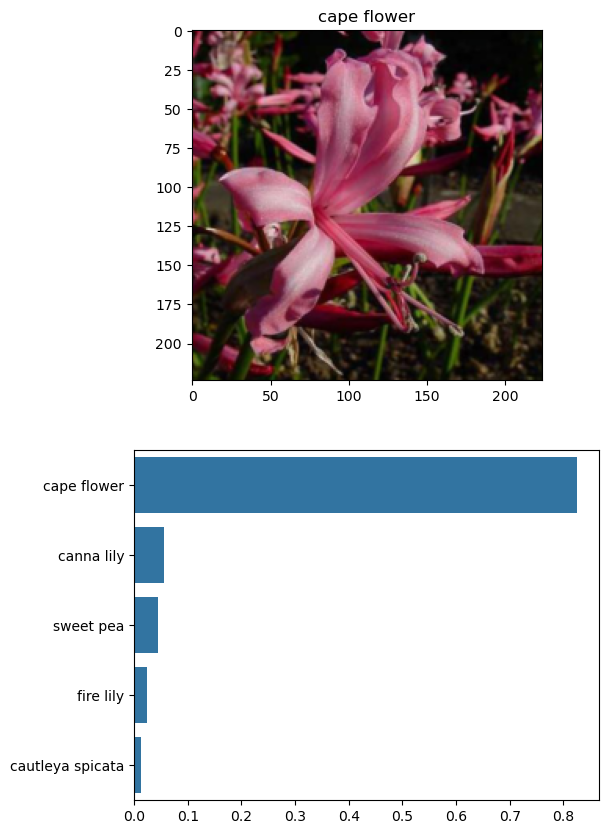

In [141]:
# TODO: Display an image along with the top 5 classes
# TODO: Display an image along with the top 5 classes
# Define image path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = "flowers/test/37/image_03734.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

new_model = loading_the_checkpoint('model_checkpoint.pth')
# Make prediction
probs, labs, flowers = predict(image_path, new_model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()